In [53]:
import csv
import pandas
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [54]:
filename = '/yourpath/shortjokes.csv'

In [55]:
df = pandas.read_csv(filename)
print(df)

            ID                                               Joke
0            1  [me narrating a documentary about narrators] "...
1            2  Telling my daughter garlic is good for you. Go...
2            3  I've been going through a really rough period ...
3            4  If I could have dinner with anyone, dead or al...
4            5     Two guys walk into a bar. The third guy ducks.
...        ...                                                ...
231652  231653                The Spicy Sausage by Delia Katessen
231653  231654  TIL That I Shouldn't have gone to law school, ...
231654  231655  What did the RAM stick say to the politician? ...
231655  231656  what do you call a play about victorian era me...
231656  231657  Calculus should be taught in every high school...

[231657 rows x 2 columns]


In [56]:
#Convert the dataframe into a dictionary
data = dict(zip(df.ID, df.Joke))

In [1]:
#print(data[10420])

In [58]:
#create a list of jokes
jokes = list(data.values())
jokes = [j.lower() for j in jokes] #lowercase everything

In [2]:
#print(jokes[2:4])

In [337]:
#taking a sample of 2K jokes from the original set of 230K - bigger samples seem to crash the kernel 
jokes_short = jokes[:2000]
len(jokes_short)

2000

In [3]:
#print(jokes_short[:10])

## Preprocessing the data with the Keras tokenizer

In [340]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(jokes_short)

In [379]:
total_words = len(tokenizer.word_index)+1


In [4]:
#print(total_words)

In [5]:
#print(tokenizer.word_index)
#print(total_words)

In [382]:
#generating ngrams for the jokes
input_sequences = []

for joke in jokes_short:
    token_list = tokenizer.texts_to_sequences([joke])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
    

In [383]:
#padding sequences

max_sequence_len = max([len(x) for x in input_sequences])-1
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

#create predictor and labels
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes = total_words)

In [6]:
#print(input_sequences.shape)
#print(ys.shape)

In [7]:
#print(tokenizer.word_index["dog"])
#print(tokenizer.word_index["ass"])
#print(tokenizer.word_index["the"])
#print(tokenizer.word_index["guy"])

In [8]:
#print(xs[95])

In [390]:
#print(tokenizer.word_index)

In [391]:
#build the model

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 39, 100)           637200    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 400)               481600    
_________________________________________________________________
dense_16 (Dense)             (None, 6372)              2555172   
Total params: 3,673,972
Trainable params: 3,673,972
Non-trainable params: 0
_________________________________________________________________


In [328]:
#compile the model with standard settings for the Adam optimizer - feel free to toggle with the custom lr parameter set in the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [330]:
#start training
history = model.fit(xs, ys, epochs = 70, verbose = 2)
print(model)

Train on 33018 samples
Epoch 1/70
33018/33018 - 106s - loss: 6.7243 - accuracy: 0.0633
Epoch 2/70
33018/33018 - 106s - loss: 6.1027 - accuracy: 0.1007
Epoch 3/70
33018/33018 - 107s - loss: 5.5528 - accuracy: 0.1301
Epoch 4/70
33018/33018 - 98s - loss: 5.0114 - accuracy: 0.1535
Epoch 5/70
33018/33018 - 94s - loss: 4.4840 - accuracy: 0.1835
Epoch 6/70
33018/33018 - 92s - loss: 3.9806 - accuracy: 0.2318
Epoch 7/70
33018/33018 - 92s - loss: 3.5074 - accuracy: 0.2999
Epoch 8/70
33018/33018 - 92s - loss: 3.0795 - accuracy: 0.3735
Epoch 9/70
33018/33018 - 92s - loss: 2.7017 - accuracy: 0.4395
Epoch 10/70
33018/33018 - 93s - loss: 2.3682 - accuracy: 0.5065
Epoch 11/70
33018/33018 - 92s - loss: 2.0834 - accuracy: 0.5616
Epoch 12/70
33018/33018 - 92s - loss: 1.8251 - accuracy: 0.6174
Epoch 13/70
33018/33018 - 92s - loss: 1.6015 - accuracy: 0.6664
Epoch 14/70
33018/33018 - 107s - loss: 1.4010 - accuracy: 0.7099
Epoch 15/70
33018/33018 - 99s - loss: 1.2237 - accuracy: 0.7535
Epoch 16/70
33018/3301

In [331]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

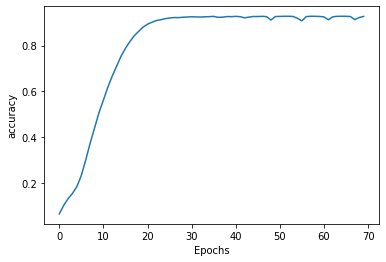

In [332]:
plot_graphs(history, 'accuracy')

In [333]:
seed_text = "a guy walks into a bar"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

blue whale joke is the best part about a redneck family piece


In [360]:
#saving the trained model
model.save('./model_saved', save_format = 'tf')